# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 16 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/50, Loss: 0.8985
Epoch 1/200, Iteration 2/50, Loss: 1.1305
Epoch 1/200, Iteration 3/50, Loss: 1.3890
Epoch 1/200, Iteration 4/50, Loss: 1.6907
Epoch 1/200, Iteration 5/50, Loss: 1.3441
Epoch 1/200, Iteration 6/50, Loss: 1.0264
Epoch 1/200, Iteration 7/50, Loss: 0.6551
Epoch 1/200, Iteration 8/50, Loss: 0.5427
Epoch 1/200, Iteration 9/50, Loss: 0.4080
Epoch 1/200, Iteration 10/50, Loss: 0.7587
Epoch 1/200, Iteration 11/50, Loss: 0.6687
Epoch 1/200, Iteration 12/50, Loss: 0.5133
Epoch 1/200, Iteration 13/50, Loss: 0.5024
Epoch 1/200, Iteration 14/50, Loss: 0.4709
Epoch 1/200, Iteration 15/50, Loss: 0.4840
Epoch 1/200, Iteration 16/50, Loss: 0.5166
Epoch 1/200, Iteration 17/50, Loss: 0.5597
Epoch 1/200, Iteration 18/50, Loss: 0.5526
Epoch 1/200, Iteration 19/50, Loss: 0.4814
Epoch 1/200, Iteration 20/50, Loss: 0.4764
Epoch 1/200, Iteration 21/50, Loss: 0.4631
Epoch 1/200, Iteration 22/50, Loss: 0.5043
Epoch 1/200, Iteration 23/50, Loss: 0.5516
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 30.25%, Avg loss: 0.357882, MRE: 0.288879, MAE: 0.047903 

Test Error: 
 Accuracy: 33.0%, Avg loss: 0.357095, MRE: 0.263562, MAE: 0.048487 

Epoch 5/200, Iteration 1/50, Loss: 0.3292
Epoch 5/200, Iteration 2/50, Loss: 0.2744
Epoch 5/200, Iteration 3/50, Loss: 0.1663
Epoch 5/200, Iteration 4/50, Loss: 0.2764
Epoch 5/200, Iteration 5/50, Loss: 0.2230
Epoch 5/200, Iteration 6/50, Loss: 0.2619
Epoch 5/200, Iteration 7/50, Loss: 0.2915
Epoch 5/200, Iteration 8/50, Loss: 0.2029
Epoch 5/200, Iteration 9/50, Loss: 0.1991
Epoch 5/200, Iteration 10/50, Loss: 0.1877
Epoch 5/200, Iteration 11/50, Loss: 0.1632
Epoch 5/200, Iteration 12/50, Loss: 0.2360
Epoch 5/200, Iteration 13/50, Loss: 0.2326
Epoch 5/200, Iteration 14/50, Loss: 0.3106
Epoch 5/200, Iteration 15/50, Loss: 0.2758
Epoch 5/200, Iteration 16/50, Loss: 0.2467
Epoch 5/200, Iteration 17/50, Loss: 0.2425
Epoch 5/200, Iteration 18/50, Loss: 0.2986
Epoch 5/200, Iteration 19/50, Loss: 0.2408
Epoch 5/200, Iteration 20/

Epoch 8/200, Iteration 28/50, Loss: 0.2002
Epoch 8/200, Iteration 29/50, Loss: 0.3207
Epoch 8/200, Iteration 30/50, Loss: 0.2044
Epoch 8/200, Iteration 31/50, Loss: 0.2573
Epoch 8/200, Iteration 32/50, Loss: 0.1490
Epoch 8/200, Iteration 33/50, Loss: 0.2940
Epoch 8/200, Iteration 34/50, Loss: 0.2672
Epoch 8/200, Iteration 35/50, Loss: 0.1903
Epoch 8/200, Iteration 36/50, Loss: 0.1617
Epoch 8/200, Iteration 37/50, Loss: 0.2533
Epoch 8/200, Iteration 38/50, Loss: 0.2459
Epoch 8/200, Iteration 39/50, Loss: 0.2426
Epoch 8/200, Iteration 40/50, Loss: 0.1740
Epoch 8/200, Iteration 41/50, Loss: 0.2162
Epoch 8/200, Iteration 42/50, Loss: 0.2041
Epoch 8/200, Iteration 43/50, Loss: 0.2370
Epoch 8/200, Iteration 44/50, Loss: 0.4072
Epoch 8/200, Iteration 45/50, Loss: 0.4188
Epoch 8/200, Iteration 46/50, Loss: 0.3279
Epoch 8/200, Iteration 47/50, Loss: 0.3560
Epoch 8/200, Iteration 48/50, Loss: 0.4147
Epoch 8/200, Iteration 49/50, Loss: 0.2715
Epoch 8/200, Iteration 50/50, Loss: 0.2747
Train Error

Epoch 12/200, Iteration 28/50, Loss: 0.2056
Epoch 12/200, Iteration 29/50, Loss: 0.1983
Epoch 12/200, Iteration 30/50, Loss: 0.2324
Epoch 12/200, Iteration 31/50, Loss: 0.1789
Epoch 12/200, Iteration 32/50, Loss: 0.1742
Epoch 12/200, Iteration 33/50, Loss: 0.1712
Epoch 12/200, Iteration 34/50, Loss: 0.1603
Epoch 12/200, Iteration 35/50, Loss: 0.2362
Epoch 12/200, Iteration 36/50, Loss: 0.2723
Epoch 12/200, Iteration 37/50, Loss: 0.1798
Epoch 12/200, Iteration 38/50, Loss: 0.2678
Epoch 12/200, Iteration 39/50, Loss: 0.3727
Epoch 12/200, Iteration 40/50, Loss: 0.2642
Epoch 12/200, Iteration 41/50, Loss: 0.2393
Epoch 12/200, Iteration 42/50, Loss: 0.2223
Epoch 12/200, Iteration 43/50, Loss: 0.2770
Epoch 12/200, Iteration 44/50, Loss: 0.1713
Epoch 12/200, Iteration 45/50, Loss: 0.1717
Epoch 12/200, Iteration 46/50, Loss: 0.1952
Epoch 12/200, Iteration 47/50, Loss: 0.1547
Epoch 12/200, Iteration 48/50, Loss: 0.1347
Epoch 12/200, Iteration 49/50, Loss: 0.1971
Epoch 12/200, Iteration 50/50, L

Epoch 16/200, Iteration 34/50, Loss: 0.1659
Epoch 16/200, Iteration 35/50, Loss: 0.2187
Epoch 16/200, Iteration 36/50, Loss: 0.2224
Epoch 16/200, Iteration 37/50, Loss: 0.1830
Epoch 16/200, Iteration 38/50, Loss: 0.1265
Epoch 16/200, Iteration 39/50, Loss: 0.2088
Epoch 16/200, Iteration 40/50, Loss: 0.3455
Epoch 16/200, Iteration 41/50, Loss: 0.1595
Epoch 16/200, Iteration 42/50, Loss: 0.2049
Epoch 16/200, Iteration 43/50, Loss: 0.1722
Epoch 16/200, Iteration 44/50, Loss: 0.2029
Epoch 16/200, Iteration 45/50, Loss: 0.1629
Epoch 16/200, Iteration 46/50, Loss: 0.2112
Epoch 16/200, Iteration 47/50, Loss: 0.1480
Epoch 16/200, Iteration 48/50, Loss: 0.1598
Epoch 16/200, Iteration 49/50, Loss: 0.2138
Epoch 16/200, Iteration 50/50, Loss: 0.1744
Train Error: 
 Accuracy: 54.5%, Avg loss: 0.169433, MRE: 0.140042, MAE: 0.021960 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.164922, MRE: 0.125737, MAE: 0.022209 

Epoch 17/200, Iteration 1/50, Loss: 0.1465
Epoch 17/200, Iteration 2/50, Loss: 0.1800
E

Epoch 20/200, Iteration 12/50, Loss: 0.3373
Epoch 20/200, Iteration 13/50, Loss: 0.2127
Epoch 20/200, Iteration 14/50, Loss: 0.1598
Epoch 20/200, Iteration 15/50, Loss: 0.2345
Epoch 20/200, Iteration 16/50, Loss: 0.2490
Epoch 20/200, Iteration 17/50, Loss: 0.1267
Epoch 20/200, Iteration 18/50, Loss: 0.1414
Epoch 20/200, Iteration 19/50, Loss: 0.1461
Epoch 20/200, Iteration 20/50, Loss: 0.2367
Epoch 20/200, Iteration 21/50, Loss: 0.2272
Epoch 20/200, Iteration 22/50, Loss: 0.2905
Epoch 20/200, Iteration 23/50, Loss: 0.1656
Epoch 20/200, Iteration 24/50, Loss: 0.2270
Epoch 20/200, Iteration 25/50, Loss: 0.2529
Epoch 20/200, Iteration 26/50, Loss: 0.2138
Epoch 20/200, Iteration 27/50, Loss: 0.1950
Epoch 20/200, Iteration 28/50, Loss: 0.1422
Epoch 20/200, Iteration 29/50, Loss: 0.1955
Epoch 20/200, Iteration 30/50, Loss: 0.2517
Epoch 20/200, Iteration 31/50, Loss: 0.2077
Epoch 20/200, Iteration 32/50, Loss: 0.2946
Epoch 20/200, Iteration 33/50, Loss: 0.2737
Epoch 20/200, Iteration 34/50, L

Epoch 23/200, Iteration 42/50, Loss: 0.2205
Epoch 23/200, Iteration 43/50, Loss: 0.1452
Epoch 23/200, Iteration 44/50, Loss: 0.1897
Epoch 23/200, Iteration 45/50, Loss: 0.3051
Epoch 23/200, Iteration 46/50, Loss: 0.2180
Epoch 23/200, Iteration 47/50, Loss: 0.2131
Epoch 23/200, Iteration 48/50, Loss: 0.2280
Epoch 23/200, Iteration 49/50, Loss: 0.1635
Epoch 23/200, Iteration 50/50, Loss: 0.1949
Train Error: 
 Accuracy: 88.5%, Avg loss: 0.214869, MRE: 0.156380, MAE: 0.026350 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.219263, MRE: 0.153092, MAE: 0.026519 

Epoch 24/200, Iteration 1/50, Loss: 0.2110
Epoch 24/200, Iteration 2/50, Loss: 0.1943
Epoch 24/200, Iteration 3/50, Loss: 0.1969
Epoch 24/200, Iteration 4/50, Loss: 0.2138
Epoch 24/200, Iteration 5/50, Loss: 0.1521
Epoch 24/200, Iteration 6/50, Loss: 0.1979
Epoch 24/200, Iteration 7/50, Loss: 0.2495
Epoch 24/200, Iteration 8/50, Loss: 0.1537
Epoch 24/200, Iteration 9/50, Loss: 0.2598
Epoch 24/200, Iteration 10/50, Loss: 0.2097
Epoch 24

Epoch 27/200, Iteration 17/50, Loss: 0.2683
Epoch 27/200, Iteration 18/50, Loss: 0.2452
Epoch 27/200, Iteration 19/50, Loss: 0.2466
Epoch 27/200, Iteration 20/50, Loss: 0.1606
Epoch 27/200, Iteration 21/50, Loss: 0.2720
Epoch 27/200, Iteration 22/50, Loss: 0.3133
Epoch 27/200, Iteration 23/50, Loss: 0.2035
Epoch 27/200, Iteration 24/50, Loss: 0.2215
Epoch 27/200, Iteration 25/50, Loss: 0.3051
Epoch 27/200, Iteration 26/50, Loss: 0.2368
Epoch 27/200, Iteration 27/50, Loss: 0.2437
Epoch 27/200, Iteration 28/50, Loss: 0.3135
Epoch 27/200, Iteration 29/50, Loss: 0.1587
Epoch 27/200, Iteration 30/50, Loss: 0.2960
Epoch 27/200, Iteration 31/50, Loss: 0.4257
Epoch 27/200, Iteration 32/50, Loss: 0.3205
Epoch 27/200, Iteration 33/50, Loss: 0.1836
Epoch 27/200, Iteration 34/50, Loss: 0.3168
Epoch 27/200, Iteration 35/50, Loss: 0.3013
Epoch 27/200, Iteration 36/50, Loss: 0.2733
Epoch 27/200, Iteration 37/50, Loss: 0.2815
Epoch 27/200, Iteration 38/50, Loss: 0.3208
Epoch 27/200, Iteration 39/50, L

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.365412, MRE: 0.210170, MAE: 0.048755 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.381981, MRE: 0.199378, MAE: 0.050609 

Epoch 31/200, Iteration 1/50, Loss: 0.3478
Epoch 31/200, Iteration 2/50, Loss: 0.3995
Epoch 31/200, Iteration 3/50, Loss: 0.2747
Epoch 31/200, Iteration 4/50, Loss: 0.3202
Epoch 31/200, Iteration 5/50, Loss: 0.1848
Epoch 31/200, Iteration 6/50, Loss: 0.1910
Epoch 31/200, Iteration 7/50, Loss: 0.2238
Epoch 31/200, Iteration 8/50, Loss: 0.1913
Epoch 31/200, Iteration 9/50, Loss: 0.2039
Epoch 31/200, Iteration 10/50, Loss: 0.2564
Epoch 31/200, Iteration 11/50, Loss: 0.2975
Epoch 31/200, Iteration 12/50, Loss: 0.2831
Epoch 31/200, Iteration 13/50, Loss: 0.2640
Epoch 31/200, Iteration 14/50, Loss: 0.2186
Epoch 31/200, Iteration 15/50, Loss: 0.2047
Epoch 31/200, Iteration 16/50, Loss: 0.2271
Epoch 31/200, Iteration 17/50, Loss: 0.1150
Epoch 31/200, Iteration 18/50, Loss: 0.1795
Epoch 31/200, Iteration 19/50, Loss: 0.1801
Epoch 3

Epoch 34/200, Iteration 33/50, Loss: 0.0775
Epoch 34/200, Iteration 34/50, Loss: 0.0635
Epoch 34/200, Iteration 35/50, Loss: 0.0614
Epoch 34/200, Iteration 36/50, Loss: 0.0762
Epoch 34/200, Iteration 37/50, Loss: 0.0674
Epoch 34/200, Iteration 38/50, Loss: 0.0566
Epoch 34/200, Iteration 39/50, Loss: 0.0626
Epoch 34/200, Iteration 40/50, Loss: 0.0712
Epoch 34/200, Iteration 41/50, Loss: 0.0423
Epoch 34/200, Iteration 42/50, Loss: 0.0598
Epoch 34/200, Iteration 43/50, Loss: 0.0711
Epoch 34/200, Iteration 44/50, Loss: 0.0549
Epoch 34/200, Iteration 45/50, Loss: 0.0525
Epoch 34/200, Iteration 46/50, Loss: 0.0844
Epoch 34/200, Iteration 47/50, Loss: 0.0873
Epoch 34/200, Iteration 48/50, Loss: 0.0891
Epoch 34/200, Iteration 49/50, Loss: 0.0991
Epoch 34/200, Iteration 50/50, Loss: 0.1023
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.078295, MRE: 0.060971, MAE: 0.010189 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.087331, MRE: 0.053757, MAE: 0.011180 

Epoch 35/200, Iteration 1/50, Loss: 0.0836

Epoch 38/200, Iteration 12/50, Loss: 0.0388
Epoch 38/200, Iteration 13/50, Loss: 0.0426
Epoch 38/200, Iteration 14/50, Loss: 0.0497
Epoch 38/200, Iteration 15/50, Loss: 0.0497
Epoch 38/200, Iteration 16/50, Loss: 0.0708
Epoch 38/200, Iteration 17/50, Loss: 0.0515
Epoch 38/200, Iteration 18/50, Loss: 0.0534
Epoch 38/200, Iteration 19/50, Loss: 0.0521
Epoch 38/200, Iteration 20/50, Loss: 0.0539
Epoch 38/200, Iteration 21/50, Loss: 0.0511
Epoch 38/200, Iteration 22/50, Loss: 0.0363
Epoch 38/200, Iteration 23/50, Loss: 0.0656
Epoch 38/200, Iteration 24/50, Loss: 0.0511
Epoch 38/200, Iteration 25/50, Loss: 0.0357
Epoch 38/200, Iteration 26/50, Loss: 0.0417
Epoch 38/200, Iteration 27/50, Loss: 0.0500
Epoch 38/200, Iteration 28/50, Loss: 0.0746
Epoch 38/200, Iteration 29/50, Loss: 0.0592
Epoch 38/200, Iteration 30/50, Loss: 0.0469
Epoch 38/200, Iteration 31/50, Loss: 0.0601
Epoch 38/200, Iteration 32/50, Loss: 0.0796
Epoch 38/200, Iteration 33/50, Loss: 0.0444
Epoch 38/200, Iteration 34/50, L

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.050092, MRE: 0.039958, MAE: 0.006245 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.062534, MRE: 0.039501, MAE: 0.007719 

Epoch 42/200, Iteration 1/50, Loss: 0.0420
Epoch 42/200, Iteration 2/50, Loss: 0.0602
Epoch 42/200, Iteration 3/50, Loss: 0.0559
Epoch 42/200, Iteration 4/50, Loss: 0.0524
Epoch 42/200, Iteration 5/50, Loss: 0.0434
Epoch 42/200, Iteration 6/50, Loss: 0.0482
Epoch 42/200, Iteration 7/50, Loss: 0.0483
Epoch 42/200, Iteration 8/50, Loss: 0.0509
Epoch 42/200, Iteration 9/50, Loss: 0.0454
Epoch 42/200, Iteration 10/50, Loss: 0.0471
Epoch 42/200, Iteration 11/50, Loss: 0.0627
Epoch 42/200, Iteration 12/50, Loss: 0.0344
Epoch 42/200, Iteration 13/50, Loss: 0.0371
Epoch 42/200, Iteration 14/50, Loss: 0.0360
Epoch 42/200, Iteration 15/50, Loss: 0.0644
Epoch 42/200, Iteration 16/50, Loss: 0.0326
Epoch 42/200, Iteration 17/50, Loss: 0.0536
Epoch 42/200, Iteration 18/50, Loss: 0.0344
Epoch 42/200, Iteration 19/50, Loss: 0.0420
Epoch 42

Epoch 45/200, Iteration 41/50, Loss: 0.0365
Epoch 45/200, Iteration 42/50, Loss: 0.0335
Epoch 45/200, Iteration 43/50, Loss: 0.0345
Epoch 45/200, Iteration 44/50, Loss: 0.0351
Epoch 45/200, Iteration 45/50, Loss: 0.0441
Epoch 45/200, Iteration 46/50, Loss: 0.0356
Epoch 45/200, Iteration 47/50, Loss: 0.0526
Epoch 45/200, Iteration 48/50, Loss: 0.0293
Epoch 45/200, Iteration 49/50, Loss: 0.0462
Epoch 45/200, Iteration 50/50, Loss: 0.0397
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.051474, MRE: 0.039213, MAE: 0.006286 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.059497, MRE: 0.039084, MAE: 0.007373 

Epoch 46/200, Iteration 1/50, Loss: 0.0524
Epoch 46/200, Iteration 2/50, Loss: 0.0436
Epoch 46/200, Iteration 3/50, Loss: 0.0436
Epoch 46/200, Iteration 4/50, Loss: 0.0704
Epoch 46/200, Iteration 5/50, Loss: 0.0469
Epoch 46/200, Iteration 6/50, Loss: 0.0305
Epoch 46/200, Iteration 7/50, Loss: 0.0416
Epoch 46/200, Iteration 8/50, Loss: 0.0435
Epoch 46/200, Iteration 9/50, Loss: 0.0450
Epoch 4

Epoch 49/200, Iteration 37/50, Loss: 0.0406
Epoch 49/200, Iteration 38/50, Loss: 0.0342
Epoch 49/200, Iteration 39/50, Loss: 0.0400
Epoch 49/200, Iteration 40/50, Loss: 0.0444
Epoch 49/200, Iteration 41/50, Loss: 0.0295
Epoch 49/200, Iteration 42/50, Loss: 0.0329
Epoch 49/200, Iteration 43/50, Loss: 0.0377
Epoch 49/200, Iteration 44/50, Loss: 0.0423
Epoch 49/200, Iteration 45/50, Loss: 0.0389
Epoch 49/200, Iteration 46/50, Loss: 0.0339
Epoch 49/200, Iteration 47/50, Loss: 0.0340
Epoch 49/200, Iteration 48/50, Loss: 0.0407
Epoch 49/200, Iteration 49/50, Loss: 0.0303
Epoch 49/200, Iteration 50/50, Loss: 0.0346
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.033375, MRE: 0.025840, MAE: 0.004484 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.045038, MRE: 0.029983, MAE: 0.005756 

Epoch 50/200, Iteration 1/50, Loss: 0.0362
Epoch 50/200, Iteration 2/50, Loss: 0.0432
Epoch 50/200, Iteration 3/50, Loss: 0.0304
Epoch 50/200, Iteration 4/50, Loss: 0.0290
Epoch 50/200, Iteration 5/50, Loss: 0.0316
Epo

Epoch 53/200, Iteration 13/50, Loss: 0.0352
Epoch 53/200, Iteration 14/50, Loss: 0.0626
Epoch 53/200, Iteration 15/50, Loss: 0.0488
Epoch 53/200, Iteration 16/50, Loss: 0.0350
Epoch 53/200, Iteration 17/50, Loss: 0.0449
Epoch 53/200, Iteration 18/50, Loss: 0.0359
Epoch 53/200, Iteration 19/50, Loss: 0.0399
Epoch 53/200, Iteration 20/50, Loss: 0.0416
Epoch 53/200, Iteration 21/50, Loss: 0.0240
Epoch 53/200, Iteration 22/50, Loss: 0.0385
Epoch 53/200, Iteration 23/50, Loss: 0.0424
Epoch 53/200, Iteration 24/50, Loss: 0.0464
Epoch 53/200, Iteration 25/50, Loss: 0.0473
Epoch 53/200, Iteration 26/50, Loss: 0.0351
Epoch 53/200, Iteration 27/50, Loss: 0.0531
Epoch 53/200, Iteration 28/50, Loss: 0.0546
Epoch 53/200, Iteration 29/50, Loss: 0.0427
Epoch 53/200, Iteration 30/50, Loss: 0.0277
Epoch 53/200, Iteration 31/50, Loss: 0.0380
Epoch 53/200, Iteration 32/50, Loss: 0.0385
Epoch 53/200, Iteration 33/50, Loss: 0.0394
Epoch 53/200, Iteration 34/50, Loss: 0.0494
Epoch 53/200, Iteration 35/50, L

Epoch 56/200, Iteration 40/50, Loss: 0.0298
Epoch 56/200, Iteration 41/50, Loss: 0.0374
Epoch 56/200, Iteration 42/50, Loss: 0.0380
Epoch 56/200, Iteration 43/50, Loss: 0.0350
Epoch 56/200, Iteration 44/50, Loss: 0.0257
Epoch 56/200, Iteration 45/50, Loss: 0.0376
Epoch 56/200, Iteration 46/50, Loss: 0.0353
Epoch 56/200, Iteration 47/50, Loss: 0.0417
Epoch 56/200, Iteration 48/50, Loss: 0.0445
Epoch 56/200, Iteration 49/50, Loss: 0.0333
Epoch 56/200, Iteration 50/50, Loss: 0.0312
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.033681, MRE: 0.024911, MAE: 0.004686 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.046579, MRE: 0.029374, MAE: 0.006164 

Epoch 57/200, Iteration 1/50, Loss: 0.0305
Epoch 57/200, Iteration 2/50, Loss: 0.0405
Epoch 57/200, Iteration 3/50, Loss: 0.0301
Epoch 57/200, Iteration 4/50, Loss: 0.0333
Epoch 57/200, Iteration 5/50, Loss: 0.0410
Epoch 57/200, Iteration 6/50, Loss: 0.0403
Epoch 57/200, Iteration 7/50, Loss: 0.0289
Epoch 57/200, Iteration 8/50, Loss: 0.0436
Epoch 

Epoch 60/200, Iteration 21/50, Loss: 0.0358
Epoch 60/200, Iteration 22/50, Loss: 0.0466
Epoch 60/200, Iteration 23/50, Loss: 0.0415
Epoch 60/200, Iteration 24/50, Loss: 0.0322
Epoch 60/200, Iteration 25/50, Loss: 0.0460
Epoch 60/200, Iteration 26/50, Loss: 0.0468
Epoch 60/200, Iteration 27/50, Loss: 0.0456
Epoch 60/200, Iteration 28/50, Loss: 0.0285
Epoch 60/200, Iteration 29/50, Loss: 0.0455
Epoch 60/200, Iteration 30/50, Loss: 0.0434
Epoch 60/200, Iteration 31/50, Loss: 0.0475
Epoch 60/200, Iteration 32/50, Loss: 0.0324
Epoch 60/200, Iteration 33/50, Loss: 0.0360
Epoch 60/200, Iteration 34/50, Loss: 0.0510
Epoch 60/200, Iteration 35/50, Loss: 0.0450
Epoch 60/200, Iteration 36/50, Loss: 0.0380
Epoch 60/200, Iteration 37/50, Loss: 0.0300
Epoch 60/200, Iteration 38/50, Loss: 0.0374
Epoch 60/200, Iteration 39/50, Loss: 0.0370
Epoch 60/200, Iteration 40/50, Loss: 0.0331
Epoch 60/200, Iteration 41/50, Loss: 0.0357
Epoch 60/200, Iteration 42/50, Loss: 0.0398
Epoch 60/200, Iteration 43/50, L

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.034683, MRE: 0.024683, MAE: 0.004669 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.046979, MRE: 0.031220, MAE: 0.006091 

Epoch 64/200, Iteration 1/50, Loss: 0.0358
Epoch 64/200, Iteration 2/50, Loss: 0.0336
Epoch 64/200, Iteration 3/50, Loss: 0.0282
Epoch 64/200, Iteration 4/50, Loss: 0.0313
Epoch 64/200, Iteration 5/50, Loss: 0.0274
Epoch 64/200, Iteration 6/50, Loss: 0.0436
Epoch 64/200, Iteration 7/50, Loss: 0.0394
Epoch 64/200, Iteration 8/50, Loss: 0.0462
Epoch 64/200, Iteration 9/50, Loss: 0.0364
Epoch 64/200, Iteration 10/50, Loss: 0.0352
Epoch 64/200, Iteration 11/50, Loss: 0.0456
Epoch 64/200, Iteration 12/50, Loss: 0.0293
Epoch 64/200, Iteration 13/50, Loss: 0.0255
Epoch 64/200, Iteration 14/50, Loss: 0.0384
Epoch 64/200, Iteration 15/50, Loss: 0.0366
Epoch 64/200, Iteration 16/50, Loss: 0.0390
Epoch 64/200, Iteration 17/50, Loss: 0.0292
Epoch 64/200, Iteration 18/50, Loss: 0.0352
Epoch 64/200, Iteration 19/50, Loss: 0.0461
Epoch 6

Epoch 67/200, Iteration 46/50, Loss: 0.0264
Epoch 67/200, Iteration 47/50, Loss: 0.0277
Epoch 67/200, Iteration 48/50, Loss: 0.0397
Epoch 67/200, Iteration 49/50, Loss: 0.0273
Epoch 67/200, Iteration 50/50, Loss: 0.0387
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.037925, MRE: 0.024280, MAE: 0.005492 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.048391, MRE: 0.028562, MAE: 0.006647 

Epoch 68/200, Iteration 1/50, Loss: 0.0329
Epoch 68/200, Iteration 2/50, Loss: 0.0374
Epoch 68/200, Iteration 3/50, Loss: 0.0409
Epoch 68/200, Iteration 4/50, Loss: 0.0203
Epoch 68/200, Iteration 5/50, Loss: 0.0365
Epoch 68/200, Iteration 6/50, Loss: 0.0339
Epoch 68/200, Iteration 7/50, Loss: 0.0434
Epoch 68/200, Iteration 8/50, Loss: 0.0312
Epoch 68/200, Iteration 9/50, Loss: 0.0341
Epoch 68/200, Iteration 10/50, Loss: 0.0368
Epoch 68/200, Iteration 11/50, Loss: 0.0394
Epoch 68/200, Iteration 12/50, Loss: 0.0366
Epoch 68/200, Iteration 13/50, Loss: 0.0243
Epoch 68/200, Iteration 14/50, Loss: 0.0341
Epoch 6

Epoch 71/200, Iteration 44/50, Loss: 0.0377
Epoch 71/200, Iteration 45/50, Loss: 0.0484
Epoch 71/200, Iteration 46/50, Loss: 0.0427
Epoch 71/200, Iteration 47/50, Loss: 0.0517
Epoch 71/200, Iteration 48/50, Loss: 0.0470
Epoch 71/200, Iteration 49/50, Loss: 0.0447
Epoch 71/200, Iteration 50/50, Loss: 0.0552
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.034843, MRE: 0.022282, MAE: 0.005042 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.044422, MRE: 0.028235, MAE: 0.006037 

Epoch 72/200, Iteration 1/50, Loss: 0.0268
Epoch 72/200, Iteration 2/50, Loss: 0.0357
Epoch 72/200, Iteration 3/50, Loss: 0.0564
Epoch 72/200, Iteration 4/50, Loss: 0.0534
Epoch 72/200, Iteration 5/50, Loss: 0.0326
Epoch 72/200, Iteration 6/50, Loss: 0.0366
Epoch 72/200, Iteration 7/50, Loss: 0.0424
Epoch 72/200, Iteration 8/50, Loss: 0.0526
Epoch 72/200, Iteration 9/50, Loss: 0.0484
Epoch 72/200, Iteration 10/50, Loss: 0.0333
Epoch 72/200, Iteration 11/50, Loss: 0.0352
Epoch 72/200, Iteration 12/50, Loss: 0.0436
Epoch 7

Epoch 75/200, Iteration 43/50, Loss: 0.0417
Epoch 75/200, Iteration 44/50, Loss: 0.0408
Epoch 75/200, Iteration 45/50, Loss: 0.0382
Epoch 75/200, Iteration 46/50, Loss: 0.0273
Epoch 75/200, Iteration 47/50, Loss: 0.0310
Epoch 75/200, Iteration 48/50, Loss: 0.0251
Epoch 75/200, Iteration 49/50, Loss: 0.0329
Epoch 75/200, Iteration 50/50, Loss: 0.0305
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.026671, MRE: 0.018343, MAE: 0.003540 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.039017, MRE: 0.028017, MAE: 0.004997 

Epoch 76/200, Iteration 1/50, Loss: 0.0244
Epoch 76/200, Iteration 2/50, Loss: 0.0276
Epoch 76/200, Iteration 3/50, Loss: 0.0263
Epoch 76/200, Iteration 4/50, Loss: 0.0258
Epoch 76/200, Iteration 5/50, Loss: 0.0291
Epoch 76/200, Iteration 6/50, Loss: 0.0333
Epoch 76/200, Iteration 7/50, Loss: 0.0292
Epoch 76/200, Iteration 8/50, Loss: 0.0384
Epoch 76/200, Iteration 9/50, Loss: 0.0290
Epoch 76/200, Iteration 10/50, Loss: 0.0273
Epoch 76/200, Iteration 11/50, Loss: 0.0283
Epoch 7

Epoch 79/200, Iteration 15/50, Loss: 0.0305
Epoch 79/200, Iteration 16/50, Loss: 0.0332
Epoch 79/200, Iteration 17/50, Loss: 0.0366
Epoch 79/200, Iteration 18/50, Loss: 0.0332
Epoch 79/200, Iteration 19/50, Loss: 0.0243
Epoch 79/200, Iteration 20/50, Loss: 0.0428
Epoch 79/200, Iteration 21/50, Loss: 0.0529
Epoch 79/200, Iteration 22/50, Loss: 0.0253
Epoch 79/200, Iteration 23/50, Loss: 0.0322
Epoch 79/200, Iteration 24/50, Loss: 0.0371
Epoch 79/200, Iteration 25/50, Loss: 0.0360
Epoch 79/200, Iteration 26/50, Loss: 0.0385
Epoch 79/200, Iteration 27/50, Loss: 0.0293
Epoch 79/200, Iteration 28/50, Loss: 0.0301
Epoch 79/200, Iteration 29/50, Loss: 0.0376
Epoch 79/200, Iteration 30/50, Loss: 0.0402
Epoch 79/200, Iteration 31/50, Loss: 0.0296
Epoch 79/200, Iteration 32/50, Loss: 0.0400
Epoch 79/200, Iteration 33/50, Loss: 0.0327
Epoch 79/200, Iteration 34/50, Loss: 0.0341
Epoch 79/200, Iteration 35/50, Loss: 0.0377
Epoch 79/200, Iteration 36/50, Loss: 0.0421
Epoch 79/200, Iteration 37/50, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.030233, MRE: 0.027471, MAE: 0.003993 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.044590, MRE: 0.034442, MAE: 0.005746 

Epoch 83/200, Iteration 1/50, Loss: 0.0424
Epoch 83/200, Iteration 2/50, Loss: 0.0377
Epoch 83/200, Iteration 3/50, Loss: 0.0296
Epoch 83/200, Iteration 4/50, Loss: 0.0243
Epoch 83/200, Iteration 5/50, Loss: 0.0328
Epoch 83/200, Iteration 6/50, Loss: 0.0411
Epoch 83/200, Iteration 7/50, Loss: 0.0511
Epoch 83/200, Iteration 8/50, Loss: 0.0467
Epoch 83/200, Iteration 9/50, Loss: 0.0355
Epoch 83/200, Iteration 10/50, Loss: 0.0461
Epoch 83/200, Iteration 11/50, Loss: 0.0329
Epoch 83/200, Iteration 12/50, Loss: 0.0287
Epoch 83/200, Iteration 13/50, Loss: 0.0350
Epoch 83/200, Iteration 14/50, Loss: 0.0267
Epoch 83/200, Iteration 15/50, Loss: 0.0272
Epoch 83/200, Iteration 16/50, Loss: 0.0331
Epoch 83/200, Iteration 17/50, Loss: 0.0291
Epoch 83/200, Iteration 18/50, Loss: 0.0425
Epoch 83/200, Iteration 19/50, Loss: 0.0321
Epoch 8

Epoch 86/200, Iteration 25/50, Loss: 0.0407
Epoch 86/200, Iteration 26/50, Loss: 0.0330
Epoch 86/200, Iteration 27/50, Loss: 0.0267
Epoch 86/200, Iteration 28/50, Loss: 0.0340
Epoch 86/200, Iteration 29/50, Loss: 0.0319
Epoch 86/200, Iteration 30/50, Loss: 0.0320
Epoch 86/200, Iteration 31/50, Loss: 0.0439
Epoch 86/200, Iteration 32/50, Loss: 0.0315
Epoch 86/200, Iteration 33/50, Loss: 0.0318
Epoch 86/200, Iteration 34/50, Loss: 0.0307
Epoch 86/200, Iteration 35/50, Loss: 0.0269
Epoch 86/200, Iteration 36/50, Loss: 0.0371
Epoch 86/200, Iteration 37/50, Loss: 0.0342
Epoch 86/200, Iteration 38/50, Loss: 0.0350
Epoch 86/200, Iteration 39/50, Loss: 0.0329
Epoch 86/200, Iteration 40/50, Loss: 0.0312
Epoch 86/200, Iteration 41/50, Loss: 0.0369
Epoch 86/200, Iteration 42/50, Loss: 0.0282
Epoch 86/200, Iteration 43/50, Loss: 0.0366
Epoch 86/200, Iteration 44/50, Loss: 0.0413
Epoch 86/200, Iteration 45/50, Loss: 0.0434
Epoch 86/200, Iteration 46/50, Loss: 0.0333
Epoch 86/200, Iteration 47/50, L

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.016123, MRE: 0.011634, MAE: 0.002142 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.033985, MRE: 0.023543, MAE: 0.004378 

Epoch 90/200, Iteration 1/50, Loss: 0.0157
Epoch 90/200, Iteration 2/50, Loss: 0.0184
Epoch 90/200, Iteration 3/50, Loss: 0.0143
Epoch 90/200, Iteration 4/50, Loss: 0.0149
Epoch 90/200, Iteration 5/50, Loss: 0.0208
Epoch 90/200, Iteration 6/50, Loss: 0.0148
Epoch 90/200, Iteration 7/50, Loss: 0.0152
Epoch 90/200, Iteration 8/50, Loss: 0.0170
Epoch 90/200, Iteration 9/50, Loss: 0.0139
Epoch 90/200, Iteration 10/50, Loss: 0.0193
Epoch 90/200, Iteration 11/50, Loss: 0.0133
Epoch 90/200, Iteration 12/50, Loss: 0.0140
Epoch 90/200, Iteration 13/50, Loss: 0.0173
Epoch 90/200, Iteration 14/50, Loss: 0.0213
Epoch 90/200, Iteration 15/50, Loss: 0.0156
Epoch 90/200, Iteration 16/50, Loss: 0.0206
Epoch 90/200, Iteration 17/50, Loss: 0.0193
Epoch 90/200, Iteration 18/50, Loss: 0.0165
Epoch 90/200, Iteration 19/50, Loss: 0.0123
Epoch 9

Epoch 93/200, Iteration 31/50, Loss: 0.0136
Epoch 93/200, Iteration 32/50, Loss: 0.0149
Epoch 93/200, Iteration 33/50, Loss: 0.0105
Epoch 93/200, Iteration 34/50, Loss: 0.0124
Epoch 93/200, Iteration 35/50, Loss: 0.0117
Epoch 93/200, Iteration 36/50, Loss: 0.0150
Epoch 93/200, Iteration 37/50, Loss: 0.0126
Epoch 93/200, Iteration 38/50, Loss: 0.0149
Epoch 93/200, Iteration 39/50, Loss: 0.0150
Epoch 93/200, Iteration 40/50, Loss: 0.0171
Epoch 93/200, Iteration 41/50, Loss: 0.0139
Epoch 93/200, Iteration 42/50, Loss: 0.0260
Epoch 93/200, Iteration 43/50, Loss: 0.0170
Epoch 93/200, Iteration 44/50, Loss: 0.0131
Epoch 93/200, Iteration 45/50, Loss: 0.0202
Epoch 93/200, Iteration 46/50, Loss: 0.0147
Epoch 93/200, Iteration 47/50, Loss: 0.0131
Epoch 93/200, Iteration 48/50, Loss: 0.0124
Epoch 93/200, Iteration 49/50, Loss: 0.0138
Epoch 93/200, Iteration 50/50, Loss: 0.0165
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.013868, MRE: 0.009508, MAE: 0.001862 

Test Error: 
 Accuracy: 97.0%, Avg l

Epoch 97/200, Iteration 5/50, Loss: 0.0140
Epoch 97/200, Iteration 6/50, Loss: 0.0109
Epoch 97/200, Iteration 7/50, Loss: 0.0146
Epoch 97/200, Iteration 8/50, Loss: 0.0165
Epoch 97/200, Iteration 9/50, Loss: 0.0209
Epoch 97/200, Iteration 10/50, Loss: 0.0101
Epoch 97/200, Iteration 11/50, Loss: 0.0134
Epoch 97/200, Iteration 12/50, Loss: 0.0118
Epoch 97/200, Iteration 13/50, Loss: 0.0197
Epoch 97/200, Iteration 14/50, Loss: 0.0163
Epoch 97/200, Iteration 15/50, Loss: 0.0160
Epoch 97/200, Iteration 16/50, Loss: 0.0150
Epoch 97/200, Iteration 17/50, Loss: 0.0128
Epoch 97/200, Iteration 18/50, Loss: 0.0101
Epoch 97/200, Iteration 19/50, Loss: 0.0171
Epoch 97/200, Iteration 20/50, Loss: 0.0156
Epoch 97/200, Iteration 21/50, Loss: 0.0176
Epoch 97/200, Iteration 22/50, Loss: 0.0156
Epoch 97/200, Iteration 23/50, Loss: 0.0149
Epoch 97/200, Iteration 24/50, Loss: 0.0118
Epoch 97/200, Iteration 25/50, Loss: 0.0137
Epoch 97/200, Iteration 26/50, Loss: 0.0179
Epoch 97/200, Iteration 27/50, Loss: 

Epoch 100/200, Iteration 34/50, Loss: 0.0228
Epoch 100/200, Iteration 35/50, Loss: 0.0145
Epoch 100/200, Iteration 36/50, Loss: 0.0133
Epoch 100/200, Iteration 37/50, Loss: 0.0125
Epoch 100/200, Iteration 38/50, Loss: 0.0144
Epoch 100/200, Iteration 39/50, Loss: 0.0137
Epoch 100/200, Iteration 40/50, Loss: 0.0142
Epoch 100/200, Iteration 41/50, Loss: 0.0171
Epoch 100/200, Iteration 42/50, Loss: 0.0134
Epoch 100/200, Iteration 43/50, Loss: 0.0104
Epoch 100/200, Iteration 44/50, Loss: 0.0139
Epoch 100/200, Iteration 45/50, Loss: 0.0123
Epoch 100/200, Iteration 46/50, Loss: 0.0154
Epoch 100/200, Iteration 47/50, Loss: 0.0106
Epoch 100/200, Iteration 48/50, Loss: 0.0177
Epoch 100/200, Iteration 49/50, Loss: 0.0117
Epoch 100/200, Iteration 50/50, Loss: 0.0112
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012776, MRE: 0.008519, MAE: 0.001707 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.032956, MRE: 0.022116, MAE: 0.004215 

Epoch 101/200, Iteration 1/50, Loss: 0.0100
Epoch 101/200, Iteration 

Epoch 104/200, Iteration 2/50, Loss: 0.0141
Epoch 104/200, Iteration 3/50, Loss: 0.0117
Epoch 104/200, Iteration 4/50, Loss: 0.0139
Epoch 104/200, Iteration 5/50, Loss: 0.0131
Epoch 104/200, Iteration 6/50, Loss: 0.0117
Epoch 104/200, Iteration 7/50, Loss: 0.0116
Epoch 104/200, Iteration 8/50, Loss: 0.0211
Epoch 104/200, Iteration 9/50, Loss: 0.0137
Epoch 104/200, Iteration 10/50, Loss: 0.0125
Epoch 104/200, Iteration 11/50, Loss: 0.0127
Epoch 104/200, Iteration 12/50, Loss: 0.0111
Epoch 104/200, Iteration 13/50, Loss: 0.0118
Epoch 104/200, Iteration 14/50, Loss: 0.0114
Epoch 104/200, Iteration 15/50, Loss: 0.0140
Epoch 104/200, Iteration 16/50, Loss: 0.0125
Epoch 104/200, Iteration 17/50, Loss: 0.0109
Epoch 104/200, Iteration 18/50, Loss: 0.0150
Epoch 104/200, Iteration 19/50, Loss: 0.0172
Epoch 104/200, Iteration 20/50, Loss: 0.0106
Epoch 104/200, Iteration 21/50, Loss: 0.0105
Epoch 104/200, Iteration 22/50, Loss: 0.0123
Epoch 104/200, Iteration 23/50, Loss: 0.0141
Epoch 104/200, Ite

Epoch 107/200, Iteration 27/50, Loss: 0.0104
Epoch 107/200, Iteration 28/50, Loss: 0.0142
Epoch 107/200, Iteration 29/50, Loss: 0.0132
Epoch 107/200, Iteration 30/50, Loss: 0.0131
Epoch 107/200, Iteration 31/50, Loss: 0.0099
Epoch 107/200, Iteration 32/50, Loss: 0.0107
Epoch 107/200, Iteration 33/50, Loss: 0.0159
Epoch 107/200, Iteration 34/50, Loss: 0.0153
Epoch 107/200, Iteration 35/50, Loss: 0.0181
Epoch 107/200, Iteration 36/50, Loss: 0.0173
Epoch 107/200, Iteration 37/50, Loss: 0.0157
Epoch 107/200, Iteration 38/50, Loss: 0.0188
Epoch 107/200, Iteration 39/50, Loss: 0.0147
Epoch 107/200, Iteration 40/50, Loss: 0.0201
Epoch 107/200, Iteration 41/50, Loss: 0.0149
Epoch 107/200, Iteration 42/50, Loss: 0.0134
Epoch 107/200, Iteration 43/50, Loss: 0.0147
Epoch 107/200, Iteration 44/50, Loss: 0.0100
Epoch 107/200, Iteration 45/50, Loss: 0.0114
Epoch 107/200, Iteration 46/50, Loss: 0.0106
Epoch 107/200, Iteration 47/50, Loss: 0.0093
Epoch 107/200, Iteration 48/50, Loss: 0.0122
Epoch 107/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.013422, MRE: 0.009123, MAE: 0.001847 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.033434, MRE: 0.021657, MAE: 0.004295 

Epoch 111/200, Iteration 1/50, Loss: 0.0116
Epoch 111/200, Iteration 2/50, Loss: 0.0164
Epoch 111/200, Iteration 3/50, Loss: 0.0140
Epoch 111/200, Iteration 4/50, Loss: 0.0087
Epoch 111/200, Iteration 5/50, Loss: 0.0093
Epoch 111/200, Iteration 6/50, Loss: 0.0123
Epoch 111/200, Iteration 7/50, Loss: 0.0178
Epoch 111/200, Iteration 8/50, Loss: 0.0123
Epoch 111/200, Iteration 9/50, Loss: 0.0109
Epoch 111/200, Iteration 10/50, Loss: 0.0177
Epoch 111/200, Iteration 11/50, Loss: 0.0104
Epoch 111/200, Iteration 12/50, Loss: 0.0182
Epoch 111/200, Iteration 13/50, Loss: 0.0134
Epoch 111/200, Iteration 14/50, Loss: 0.0120
Epoch 111/200, Iteration 15/50, Loss: 0.0110
Epoch 111/200, Iteration 16/50, Loss: 0.0155
Epoch 111/200, Iteration 17/50, Loss: 0.0084
Epoch 111/200, Iteration 18/50, Loss: 0.0105
Epoch 111/200, Iteration 19/50, L

Epoch 114/200, Iteration 22/50, Loss: 0.0084
Epoch 114/200, Iteration 23/50, Loss: 0.0160
Epoch 114/200, Iteration 24/50, Loss: 0.0107
Epoch 114/200, Iteration 25/50, Loss: 0.0071
Epoch 114/200, Iteration 26/50, Loss: 0.0098
Epoch 114/200, Iteration 27/50, Loss: 0.0088
Epoch 114/200, Iteration 28/50, Loss: 0.0109
Epoch 114/200, Iteration 29/50, Loss: 0.0133
Epoch 114/200, Iteration 30/50, Loss: 0.0131
Epoch 114/200, Iteration 31/50, Loss: 0.0123
Epoch 114/200, Iteration 32/50, Loss: 0.0072
Epoch 114/200, Iteration 33/50, Loss: 0.0121
Epoch 114/200, Iteration 34/50, Loss: 0.0114
Epoch 114/200, Iteration 35/50, Loss: 0.0157
Epoch 114/200, Iteration 36/50, Loss: 0.0147
Epoch 114/200, Iteration 37/50, Loss: 0.0135
Epoch 114/200, Iteration 38/50, Loss: 0.0150
Epoch 114/200, Iteration 39/50, Loss: 0.0106
Epoch 114/200, Iteration 40/50, Loss: 0.0135
Epoch 114/200, Iteration 41/50, Loss: 0.0119
Epoch 114/200, Iteration 42/50, Loss: 0.0122
Epoch 114/200, Iteration 43/50, Loss: 0.0118
Epoch 114/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.011348, MRE: 0.008007, MAE: 0.001525 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.032213, MRE: 0.020828, MAE: 0.004070 

Epoch 118/200, Iteration 1/50, Loss: 0.0109
Epoch 118/200, Iteration 2/50, Loss: 0.0096
Epoch 118/200, Iteration 3/50, Loss: 0.0129
Epoch 118/200, Iteration 4/50, Loss: 0.0121
Epoch 118/200, Iteration 5/50, Loss: 0.0104
Epoch 118/200, Iteration 6/50, Loss: 0.0104
Epoch 118/200, Iteration 7/50, Loss: 0.0130
Epoch 118/200, Iteration 8/50, Loss: 0.0118
Epoch 118/200, Iteration 9/50, Loss: 0.0173
Epoch 118/200, Iteration 10/50, Loss: 0.0095
Epoch 118/200, Iteration 11/50, Loss: 0.0104
Epoch 118/200, Iteration 12/50, Loss: 0.0123
Epoch 118/200, Iteration 13/50, Loss: 0.0132
Epoch 118/200, Iteration 14/50, Loss: 0.0100
Epoch 118/200, Iteration 15/50, Loss: 0.0144
Epoch 118/200, Iteration 16/50, Loss: 0.0102
Epoch 118/200, Iteration 17/50, Loss: 0.0106
Epoch 118/200, Iteration 18/50, Loss: 0.0106
Epoch 118/200, Iteration 19/50, L

Epoch 121/200, Iteration 25/50, Loss: 0.0170
Epoch 121/200, Iteration 26/50, Loss: 0.0265
Epoch 121/200, Iteration 27/50, Loss: 0.0152
Epoch 121/200, Iteration 28/50, Loss: 0.0119
Epoch 121/200, Iteration 29/50, Loss: 0.0145
Epoch 121/200, Iteration 30/50, Loss: 0.0118
Epoch 121/200, Iteration 31/50, Loss: 0.0089
Epoch 121/200, Iteration 32/50, Loss: 0.0091
Epoch 121/200, Iteration 33/50, Loss: 0.0130
Epoch 121/200, Iteration 34/50, Loss: 0.0134
Epoch 121/200, Iteration 35/50, Loss: 0.0088
Epoch 121/200, Iteration 36/50, Loss: 0.0123
Epoch 121/200, Iteration 37/50, Loss: 0.0128
Epoch 121/200, Iteration 38/50, Loss: 0.0100
Epoch 121/200, Iteration 39/50, Loss: 0.0106
Epoch 121/200, Iteration 40/50, Loss: 0.0101
Epoch 121/200, Iteration 41/50, Loss: 0.0126
Epoch 121/200, Iteration 42/50, Loss: 0.0166
Epoch 121/200, Iteration 43/50, Loss: 0.0112
Epoch 121/200, Iteration 44/50, Loss: 0.0144
Epoch 121/200, Iteration 45/50, Loss: 0.0137
Epoch 121/200, Iteration 46/50, Loss: 0.0128
Epoch 121/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.010943, MRE: 0.007298, MAE: 0.001469 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.031752, MRE: 0.020652, MAE: 0.003994 

Epoch 125/200, Iteration 1/50, Loss: 0.0096
Epoch 125/200, Iteration 2/50, Loss: 0.0065
Epoch 125/200, Iteration 3/50, Loss: 0.0106
Epoch 125/200, Iteration 4/50, Loss: 0.0104
Epoch 125/200, Iteration 5/50, Loss: 0.0109
Epoch 125/200, Iteration 6/50, Loss: 0.0111
Epoch 125/200, Iteration 7/50, Loss: 0.0086
Epoch 125/200, Iteration 8/50, Loss: 0.0094
Epoch 125/200, Iteration 9/50, Loss: 0.0100
Epoch 125/200, Iteration 10/50, Loss: 0.0117
Epoch 125/200, Iteration 11/50, Loss: 0.0105
Epoch 125/200, Iteration 12/50, Loss: 0.0116
Epoch 125/200, Iteration 13/50, Loss: 0.0126
Epoch 125/200, Iteration 14/50, Loss: 0.0088
Epoch 125/200, Iteration 15/50, Loss: 0.0115
Epoch 125/200, Iteration 16/50, Loss: 0.0124
Epoch 125/200, Iteration 17/50, Loss: 0.0081
Epoch 125/200, Iteration 18/50, Loss: 0.0082
Epoch 125/200, Iteration 19/50, L

Epoch 128/200, Iteration 27/50, Loss: 0.0107
Epoch 128/200, Iteration 28/50, Loss: 0.0141
Epoch 128/200, Iteration 29/50, Loss: 0.0101
Epoch 128/200, Iteration 30/50, Loss: 0.0084
Epoch 128/200, Iteration 31/50, Loss: 0.0094
Epoch 128/200, Iteration 32/50, Loss: 0.0145
Epoch 128/200, Iteration 33/50, Loss: 0.0129
Epoch 128/200, Iteration 34/50, Loss: 0.0112
Epoch 128/200, Iteration 35/50, Loss: 0.0111
Epoch 128/200, Iteration 36/50, Loss: 0.0154
Epoch 128/200, Iteration 37/50, Loss: 0.0109
Epoch 128/200, Iteration 38/50, Loss: 0.0106
Epoch 128/200, Iteration 39/50, Loss: 0.0106
Epoch 128/200, Iteration 40/50, Loss: 0.0106
Epoch 128/200, Iteration 41/50, Loss: 0.0117
Epoch 128/200, Iteration 42/50, Loss: 0.0155
Epoch 128/200, Iteration 43/50, Loss: 0.0100
Epoch 128/200, Iteration 44/50, Loss: 0.0105
Epoch 128/200, Iteration 45/50, Loss: 0.0100
Epoch 128/200, Iteration 46/50, Loss: 0.0142
Epoch 128/200, Iteration 47/50, Loss: 0.0103
Epoch 128/200, Iteration 48/50, Loss: 0.0096
Epoch 128/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.011066, MRE: 0.008097, MAE: 0.001519 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.032348, MRE: 0.021250, MAE: 0.004069 

Epoch 132/200, Iteration 1/50, Loss: 0.0108
Epoch 132/200, Iteration 2/50, Loss: 0.0103
Epoch 132/200, Iteration 3/50, Loss: 0.0101
Epoch 132/200, Iteration 4/50, Loss: 0.0086
Epoch 132/200, Iteration 5/50, Loss: 0.0111
Epoch 132/200, Iteration 6/50, Loss: 0.0128
Epoch 132/200, Iteration 7/50, Loss: 0.0066
Epoch 132/200, Iteration 8/50, Loss: 0.0118
Epoch 132/200, Iteration 9/50, Loss: 0.0094
Epoch 132/200, Iteration 10/50, Loss: 0.0122
Epoch 132/200, Iteration 11/50, Loss: 0.0126
Epoch 132/200, Iteration 12/50, Loss: 0.0088
Epoch 132/200, Iteration 13/50, Loss: 0.0097
Epoch 132/200, Iteration 14/50, Loss: 0.0080
Epoch 132/200, Iteration 15/50, Loss: 0.0148
Epoch 132/200, Iteration 16/50, Loss: 0.0125
Epoch 132/200, Iteration 17/50, Loss: 0.0112
Epoch 132/200, Iteration 18/50, Loss: 0.0117
Epoch 132/200, Iteration 19/50, L

Epoch 135/200, Iteration 33/50, Loss: 0.0112
Epoch 135/200, Iteration 34/50, Loss: 0.0126
Epoch 135/200, Iteration 35/50, Loss: 0.0136
Epoch 135/200, Iteration 36/50, Loss: 0.0105
Epoch 135/200, Iteration 37/50, Loss: 0.0097
Epoch 135/200, Iteration 38/50, Loss: 0.0089
Epoch 135/200, Iteration 39/50, Loss: 0.0096
Epoch 135/200, Iteration 40/50, Loss: 0.0107
Epoch 135/200, Iteration 41/50, Loss: 0.0079
Epoch 135/200, Iteration 42/50, Loss: 0.0097
Epoch 135/200, Iteration 43/50, Loss: 0.0111
Epoch 135/200, Iteration 44/50, Loss: 0.0087
Epoch 135/200, Iteration 45/50, Loss: 0.0097
Epoch 135/200, Iteration 46/50, Loss: 0.0111
Epoch 135/200, Iteration 47/50, Loss: 0.0106
Epoch 135/200, Iteration 48/50, Loss: 0.0118
Epoch 135/200, Iteration 49/50, Loss: 0.0102
Epoch 135/200, Iteration 50/50, Loss: 0.0136
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.010265, MRE: 0.007025, MAE: 0.001385 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.032040, MRE: 0.020538, MAE: 0.004045 

Epoch 136/200, Iteration

Epoch 139/200, Iteration 14/50, Loss: 0.0171
Epoch 139/200, Iteration 15/50, Loss: 0.0175
Epoch 139/200, Iteration 16/50, Loss: 0.0086
Epoch 139/200, Iteration 17/50, Loss: 0.0088
Epoch 139/200, Iteration 18/50, Loss: 0.0090
Epoch 139/200, Iteration 19/50, Loss: 0.0103
Epoch 139/200, Iteration 20/50, Loss: 0.0111
Epoch 139/200, Iteration 21/50, Loss: 0.0108
Epoch 139/200, Iteration 22/50, Loss: 0.0107
Epoch 139/200, Iteration 23/50, Loss: 0.0123
Epoch 139/200, Iteration 24/50, Loss: 0.0121
Epoch 139/200, Iteration 25/50, Loss: 0.0112
Epoch 139/200, Iteration 26/50, Loss: 0.0108
Epoch 139/200, Iteration 27/50, Loss: 0.0129
Epoch 139/200, Iteration 28/50, Loss: 0.0093
Epoch 139/200, Iteration 29/50, Loss: 0.0093
Epoch 139/200, Iteration 30/50, Loss: 0.0108
Epoch 139/200, Iteration 31/50, Loss: 0.0107
Epoch 139/200, Iteration 32/50, Loss: 0.0136
Epoch 139/200, Iteration 33/50, Loss: 0.0140
Epoch 139/200, Iteration 34/50, Loss: 0.0103
Epoch 139/200, Iteration 35/50, Loss: 0.0085
Epoch 139/

Epoch 142/200, Iteration 47/50, Loss: 0.0101
Epoch 142/200, Iteration 48/50, Loss: 0.0089
Epoch 142/200, Iteration 49/50, Loss: 0.0095
Epoch 142/200, Iteration 50/50, Loss: 0.0092
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.011171, MRE: 0.007606, MAE: 0.001464 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.031832, MRE: 0.020672, MAE: 0.003983 

Epoch 143/200, Iteration 1/50, Loss: 0.0080
Epoch 143/200, Iteration 2/50, Loss: 0.0088
Epoch 143/200, Iteration 3/50, Loss: 0.0107
Epoch 143/200, Iteration 4/50, Loss: 0.0148
Epoch 143/200, Iteration 5/50, Loss: 0.0095
Epoch 143/200, Iteration 6/50, Loss: 0.0119
Epoch 143/200, Iteration 7/50, Loss: 0.0103
Epoch 143/200, Iteration 8/50, Loss: 0.0079
Epoch 143/200, Iteration 9/50, Loss: 0.0066
Epoch 143/200, Iteration 10/50, Loss: 0.0119
Epoch 143/200, Iteration 11/50, Loss: 0.0087
Epoch 143/200, Iteration 12/50, Loss: 0.0138
Epoch 143/200, Iteration 13/50, Loss: 0.0143
Epoch 143/200, Iteration 14/50, Loss: 0.0075
Epoch 143/200, Iteration 15/50, L

Epoch 146/200, Iteration 28/50, Loss: 0.0124
Epoch 146/200, Iteration 29/50, Loss: 0.0163
Epoch 146/200, Iteration 30/50, Loss: 0.0091
Epoch 146/200, Iteration 31/50, Loss: 0.0119
Epoch 146/200, Iteration 32/50, Loss: 0.0099
Epoch 146/200, Iteration 33/50, Loss: 0.0095
Epoch 146/200, Iteration 34/50, Loss: 0.0104
Epoch 146/200, Iteration 35/50, Loss: 0.0084
Epoch 146/200, Iteration 36/50, Loss: 0.0120
Epoch 146/200, Iteration 37/50, Loss: 0.0097
Epoch 146/200, Iteration 38/50, Loss: 0.0103
Epoch 146/200, Iteration 39/50, Loss: 0.0127
Epoch 146/200, Iteration 40/50, Loss: 0.0127
Epoch 146/200, Iteration 41/50, Loss: 0.0121
Epoch 146/200, Iteration 42/50, Loss: 0.0108
Epoch 146/200, Iteration 43/50, Loss: 0.0126
Epoch 146/200, Iteration 44/50, Loss: 0.0176
Epoch 146/200, Iteration 45/50, Loss: 0.0117
Epoch 146/200, Iteration 46/50, Loss: 0.0169
Epoch 146/200, Iteration 47/50, Loss: 0.0131
Epoch 146/200, Iteration 48/50, Loss: 0.0120
Epoch 146/200, Iteration 49/50, Loss: 0.0098
Epoch 146/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.010606, MRE: 0.007699, MAE: 0.001427 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.032423, MRE: 0.020729, MAE: 0.004095 

Epoch 150/200, Iteration 1/50, Loss: 0.0129
Epoch 150/200, Iteration 2/50, Loss: 0.0197
Epoch 150/200, Iteration 3/50, Loss: 0.0104
Epoch 150/200, Iteration 4/50, Loss: 0.0113
Epoch 150/200, Iteration 5/50, Loss: 0.0069
Epoch 150/200, Iteration 6/50, Loss: 0.0095
Epoch 150/200, Iteration 7/50, Loss: 0.0101
Epoch 150/200, Iteration 8/50, Loss: 0.0091
Epoch 150/200, Iteration 9/50, Loss: 0.0095
Epoch 150/200, Iteration 10/50, Loss: 0.0067
Epoch 150/200, Iteration 11/50, Loss: 0.0103
Epoch 150/200, Iteration 12/50, Loss: 0.0095
Epoch 150/200, Iteration 13/50, Loss: 0.0083
Epoch 150/200, Iteration 14/50, Loss: 0.0078
Epoch 150/200, Iteration 15/50, Loss: 0.0088
Epoch 150/200, Iteration 16/50, Loss: 0.0083
Epoch 150/200, Iteration 17/50, Loss: 0.0084
Epoch 150/200, Iteration 18/50, Loss: 0.0080
Epoch 150/200, Iteration 19/50, L

Epoch 153/200, Iteration 31/50, Loss: 0.0083
Epoch 153/200, Iteration 32/50, Loss: 0.0076
Epoch 153/200, Iteration 33/50, Loss: 0.0088
Epoch 153/200, Iteration 34/50, Loss: 0.0080
Epoch 153/200, Iteration 35/50, Loss: 0.0093
Epoch 153/200, Iteration 36/50, Loss: 0.0120
Epoch 153/200, Iteration 37/50, Loss: 0.0111
Epoch 153/200, Iteration 38/50, Loss: 0.0128
Epoch 153/200, Iteration 39/50, Loss: 0.0096
Epoch 153/200, Iteration 40/50, Loss: 0.0108
Epoch 153/200, Iteration 41/50, Loss: 0.0097
Epoch 153/200, Iteration 42/50, Loss: 0.0110
Epoch 153/200, Iteration 43/50, Loss: 0.0096
Epoch 153/200, Iteration 44/50, Loss: 0.0145
Epoch 153/200, Iteration 45/50, Loss: 0.0106
Epoch 153/200, Iteration 46/50, Loss: 0.0087
Epoch 153/200, Iteration 47/50, Loss: 0.0087
Epoch 153/200, Iteration 48/50, Loss: 0.0126
Epoch 153/200, Iteration 49/50, Loss: 0.0075
Epoch 153/200, Iteration 50/50, Loss: 0.0099
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.010398, MRE: 0.007046, MAE: 0.001378 

Test Error: 
 Ac

Epoch 157/200, Iteration 2/50, Loss: 0.0071
Epoch 157/200, Iteration 3/50, Loss: 0.0133
Epoch 157/200, Iteration 4/50, Loss: 0.0065
Epoch 157/200, Iteration 5/50, Loss: 0.0073
Epoch 157/200, Iteration 6/50, Loss: 0.0110
Epoch 157/200, Iteration 7/50, Loss: 0.0153
Epoch 157/200, Iteration 8/50, Loss: 0.0086
Epoch 157/200, Iteration 9/50, Loss: 0.0084
Epoch 157/200, Iteration 10/50, Loss: 0.0066
Epoch 157/200, Iteration 11/50, Loss: 0.0074
Epoch 157/200, Iteration 12/50, Loss: 0.0091
Epoch 157/200, Iteration 13/50, Loss: 0.0052
Epoch 157/200, Iteration 14/50, Loss: 0.0064
Epoch 157/200, Iteration 15/50, Loss: 0.0083
Epoch 157/200, Iteration 16/50, Loss: 0.0115
Epoch 157/200, Iteration 17/50, Loss: 0.0065
Epoch 157/200, Iteration 18/50, Loss: 0.0097
Epoch 157/200, Iteration 19/50, Loss: 0.0083
Epoch 157/200, Iteration 20/50, Loss: 0.0054
Epoch 157/200, Iteration 21/50, Loss: 0.0100
Epoch 157/200, Iteration 22/50, Loss: 0.0067
Epoch 157/200, Iteration 23/50, Loss: 0.0089
Epoch 157/200, Ite

Epoch 160/200, Iteration 39/50, Loss: 0.0073
Epoch 160/200, Iteration 40/50, Loss: 0.0068
Epoch 160/200, Iteration 41/50, Loss: 0.0083
Epoch 160/200, Iteration 42/50, Loss: 0.0055
Epoch 160/200, Iteration 43/50, Loss: 0.0101
Epoch 160/200, Iteration 44/50, Loss: 0.0109
Epoch 160/200, Iteration 45/50, Loss: 0.0069
Epoch 160/200, Iteration 46/50, Loss: 0.0068
Epoch 160/200, Iteration 47/50, Loss: 0.0097
Epoch 160/200, Iteration 48/50, Loss: 0.0127
Epoch 160/200, Iteration 49/50, Loss: 0.0076
Epoch 160/200, Iteration 50/50, Loss: 0.0060
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008615, MRE: 0.005830, MAE: 0.001169 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.031748, MRE: 0.020202, MAE: 0.003976 

Epoch 161/200, Iteration 1/50, Loss: 0.0052
Epoch 161/200, Iteration 2/50, Loss: 0.0066
Epoch 161/200, Iteration 3/50, Loss: 0.0104
Epoch 161/200, Iteration 4/50, Loss: 0.0090
Epoch 161/200, Iteration 5/50, Loss: 0.0042
Epoch 161/200, Iteration 6/50, Loss: 0.0095
Epoch 161/200, Iteration 7/50,

Epoch 164/200, Iteration 17/50, Loss: 0.0079
Epoch 164/200, Iteration 18/50, Loss: 0.0086
Epoch 164/200, Iteration 19/50, Loss: 0.0088
Epoch 164/200, Iteration 20/50, Loss: 0.0070
Epoch 164/200, Iteration 21/50, Loss: 0.0084
Epoch 164/200, Iteration 22/50, Loss: 0.0105
Epoch 164/200, Iteration 23/50, Loss: 0.0103
Epoch 164/200, Iteration 24/50, Loss: 0.0072
Epoch 164/200, Iteration 25/50, Loss: 0.0080
Epoch 164/200, Iteration 26/50, Loss: 0.0054
Epoch 164/200, Iteration 27/50, Loss: 0.0072
Epoch 164/200, Iteration 28/50, Loss: 0.0083
Epoch 164/200, Iteration 29/50, Loss: 0.0060
Epoch 164/200, Iteration 30/50, Loss: 0.0045
Epoch 164/200, Iteration 31/50, Loss: 0.0075
Epoch 164/200, Iteration 32/50, Loss: 0.0076
Epoch 164/200, Iteration 33/50, Loss: 0.0094
Epoch 164/200, Iteration 34/50, Loss: 0.0107
Epoch 164/200, Iteration 35/50, Loss: 0.0086
Epoch 164/200, Iteration 36/50, Loss: 0.0179
Epoch 164/200, Iteration 37/50, Loss: 0.0098
Epoch 164/200, Iteration 38/50, Loss: 0.0102
Epoch 164/

Epoch 167/200, Iteration 50/50, Loss: 0.0100
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008447, MRE: 0.005815, MAE: 0.001142 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.031875, MRE: 0.020235, MAE: 0.003997 

Epoch 168/200, Iteration 1/50, Loss: 0.0116
Epoch 168/200, Iteration 2/50, Loss: 0.0065
Epoch 168/200, Iteration 3/50, Loss: 0.0063
Epoch 168/200, Iteration 4/50, Loss: 0.0064
Epoch 168/200, Iteration 5/50, Loss: 0.0085
Epoch 168/200, Iteration 6/50, Loss: 0.0122
Epoch 168/200, Iteration 7/50, Loss: 0.0096
Epoch 168/200, Iteration 8/50, Loss: 0.0079
Epoch 168/200, Iteration 9/50, Loss: 0.0086
Epoch 168/200, Iteration 10/50, Loss: 0.0075
Epoch 168/200, Iteration 11/50, Loss: 0.0096
Epoch 168/200, Iteration 12/50, Loss: 0.0074
Epoch 168/200, Iteration 13/50, Loss: 0.0087
Epoch 168/200, Iteration 14/50, Loss: 0.0072
Epoch 168/200, Iteration 15/50, Loss: 0.0174
Epoch 168/200, Iteration 16/50, Loss: 0.0109
Epoch 168/200, Iteration 17/50, Loss: 0.0088
Epoch 168/200, Iteration 18/50, L

Epoch 171/200, Iteration 27/50, Loss: 0.0062
Epoch 171/200, Iteration 28/50, Loss: 0.0090
Epoch 171/200, Iteration 29/50, Loss: 0.0080
Epoch 171/200, Iteration 30/50, Loss: 0.0196
Epoch 171/200, Iteration 31/50, Loss: 0.0084
Epoch 171/200, Iteration 32/50, Loss: 0.0082
Epoch 171/200, Iteration 33/50, Loss: 0.0089
Epoch 171/200, Iteration 34/50, Loss: 0.0055
Epoch 171/200, Iteration 35/50, Loss: 0.0063
Epoch 171/200, Iteration 36/50, Loss: 0.0099
Epoch 171/200, Iteration 37/50, Loss: 0.0077
Epoch 171/200, Iteration 38/50, Loss: 0.0061
Epoch 171/200, Iteration 39/50, Loss: 0.0073
Epoch 171/200, Iteration 40/50, Loss: 0.0067
Epoch 171/200, Iteration 41/50, Loss: 0.0083
Epoch 171/200, Iteration 42/50, Loss: 0.0102
Epoch 171/200, Iteration 43/50, Loss: 0.0116
Epoch 171/200, Iteration 44/50, Loss: 0.0102
Epoch 171/200, Iteration 45/50, Loss: 0.0092
Epoch 171/200, Iteration 46/50, Loss: 0.0080
Epoch 171/200, Iteration 47/50, Loss: 0.0075
Epoch 171/200, Iteration 48/50, Loss: 0.0073
Epoch 171/

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008316, MRE: 0.005593, MAE: 0.001126 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.031896, MRE: 0.020240, MAE: 0.003995 

Epoch 175/200, Iteration 1/50, Loss: 0.0107
Epoch 175/200, Iteration 2/50, Loss: 0.0106
Epoch 175/200, Iteration 3/50, Loss: 0.0083
Epoch 175/200, Iteration 4/50, Loss: 0.0092
Epoch 175/200, Iteration 5/50, Loss: 0.0094
Epoch 175/200, Iteration 6/50, Loss: 0.0071
Epoch 175/200, Iteration 7/50, Loss: 0.0087
Epoch 175/200, Iteration 8/50, Loss: 0.0057
Epoch 175/200, Iteration 9/50, Loss: 0.0117
Epoch 175/200, Iteration 10/50, Loss: 0.0055
Epoch 175/200, Iteration 11/50, Loss: 0.0071
Epoch 175/200, Iteration 12/50, Loss: 0.0097
Epoch 175/200, Iteration 13/50, Loss: 0.0087
Epoch 175/200, Iteration 14/50, Loss: 0.0068
Epoch 175/200, Iteration 15/50, Loss: 0.0064
Epoch 175/200, Iteration 16/50, Loss: 0.0157
Epoch 175/200, Iteration 17/50, Loss: 0.0117
Epoch 175/200, Iteration 18/50, Loss: 0.0049
Epoch 175/200, Iteration 19/50, L

Epoch 178/200, Iteration 25/50, Loss: 0.0060
Epoch 178/200, Iteration 26/50, Loss: 0.0074
Epoch 178/200, Iteration 27/50, Loss: 0.0078
Epoch 178/200, Iteration 28/50, Loss: 0.0091
Epoch 178/200, Iteration 29/50, Loss: 0.0111
Epoch 178/200, Iteration 30/50, Loss: 0.0072
Epoch 178/200, Iteration 31/50, Loss: 0.0096
Epoch 178/200, Iteration 32/50, Loss: 0.0056
Epoch 178/200, Iteration 33/50, Loss: 0.0065
Epoch 178/200, Iteration 34/50, Loss: 0.0063
Epoch 178/200, Iteration 35/50, Loss: 0.0078
Epoch 178/200, Iteration 36/50, Loss: 0.0135
Epoch 178/200, Iteration 37/50, Loss: 0.0108
Epoch 178/200, Iteration 38/50, Loss: 0.0091
Epoch 178/200, Iteration 39/50, Loss: 0.0202
Epoch 178/200, Iteration 40/50, Loss: 0.0099
Epoch 178/200, Iteration 41/50, Loss: 0.0073
Epoch 178/200, Iteration 42/50, Loss: 0.0065
Epoch 178/200, Iteration 43/50, Loss: 0.0112
Epoch 178/200, Iteration 44/50, Loss: 0.0056
Epoch 178/200, Iteration 45/50, Loss: 0.0065
Epoch 178/200, Iteration 46/50, Loss: 0.0084
Epoch 178/

Epoch 181/200, Iteration 49/50, Loss: 0.0151
Epoch 181/200, Iteration 50/50, Loss: 0.0109
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008262, MRE: 0.005559, MAE: 0.001124 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.031932, MRE: 0.020221, MAE: 0.004004 

Epoch 182/200, Iteration 1/50, Loss: 0.0087
Epoch 182/200, Iteration 2/50, Loss: 0.0114
Epoch 182/200, Iteration 3/50, Loss: 0.0077
Epoch 182/200, Iteration 4/50, Loss: 0.0188
Epoch 182/200, Iteration 5/50, Loss: 0.0065
Epoch 182/200, Iteration 6/50, Loss: 0.0081
Epoch 182/200, Iteration 7/50, Loss: 0.0073
Epoch 182/200, Iteration 8/50, Loss: 0.0075
Epoch 182/200, Iteration 9/50, Loss: 0.0091
Epoch 182/200, Iteration 10/50, Loss: 0.0089
Epoch 182/200, Iteration 11/50, Loss: 0.0072
Epoch 182/200, Iteration 12/50, Loss: 0.0046
Epoch 182/200, Iteration 13/50, Loss: 0.0094
Epoch 182/200, Iteration 14/50, Loss: 0.0114
Epoch 182/200, Iteration 15/50, Loss: 0.0065
Epoch 182/200, Iteration 16/50, Loss: 0.0063
Epoch 182/200, Iteration 17/50, L

Epoch 185/200, Iteration 29/50, Loss: 0.0102
Epoch 185/200, Iteration 30/50, Loss: 0.0053
Epoch 185/200, Iteration 31/50, Loss: 0.0067
Epoch 185/200, Iteration 32/50, Loss: 0.0093
Epoch 185/200, Iteration 33/50, Loss: 0.0074
Epoch 185/200, Iteration 34/50, Loss: 0.0091
Epoch 185/200, Iteration 35/50, Loss: 0.0069
Epoch 185/200, Iteration 36/50, Loss: 0.0125
Epoch 185/200, Iteration 37/50, Loss: 0.0085
Epoch 185/200, Iteration 38/50, Loss: 0.0046
Epoch 185/200, Iteration 39/50, Loss: 0.0064
Epoch 185/200, Iteration 40/50, Loss: 0.0064
Epoch 185/200, Iteration 41/50, Loss: 0.0061
Epoch 185/200, Iteration 42/50, Loss: 0.0105
Epoch 185/200, Iteration 43/50, Loss: 0.0069
Epoch 185/200, Iteration 44/50, Loss: 0.0075
Epoch 185/200, Iteration 45/50, Loss: 0.0085
Epoch 185/200, Iteration 46/50, Loss: 0.0076
Epoch 185/200, Iteration 47/50, Loss: 0.0079
Epoch 185/200, Iteration 48/50, Loss: 0.0077
Epoch 185/200, Iteration 49/50, Loss: 0.0103
Epoch 185/200, Iteration 50/50, Loss: 0.0076
Train Erro

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008251, MRE: 0.005611, MAE: 0.001114 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.031819, MRE: 0.020149, MAE: 0.003982 

Epoch 189/200, Iteration 1/50, Loss: 0.0110
Epoch 189/200, Iteration 2/50, Loss: 0.0065
Epoch 189/200, Iteration 3/50, Loss: 0.0090
Epoch 189/200, Iteration 4/50, Loss: 0.0068
Epoch 189/200, Iteration 5/50, Loss: 0.0065
Epoch 189/200, Iteration 6/50, Loss: 0.0119
Epoch 189/200, Iteration 7/50, Loss: 0.0080
Epoch 189/200, Iteration 8/50, Loss: 0.0105
Epoch 189/200, Iteration 9/50, Loss: 0.0049
Epoch 189/200, Iteration 10/50, Loss: 0.0058
Epoch 189/200, Iteration 11/50, Loss: 0.0101
Epoch 189/200, Iteration 12/50, Loss: 0.0049
Epoch 189/200, Iteration 13/50, Loss: 0.0066
Epoch 189/200, Iteration 14/50, Loss: 0.0081
Epoch 189/200, Iteration 15/50, Loss: 0.0060
Epoch 189/200, Iteration 16/50, Loss: 0.0060
Epoch 189/200, Iteration 17/50, Loss: 0.0142
Epoch 189/200, Iteration 18/50, Loss: 0.0063
Epoch 189/200, Iteration 19/50, L

Epoch 192/200, Iteration 33/50, Loss: 0.0108
Epoch 192/200, Iteration 34/50, Loss: 0.0075
Epoch 192/200, Iteration 35/50, Loss: 0.0029
Epoch 192/200, Iteration 36/50, Loss: 0.0053
Epoch 192/200, Iteration 37/50, Loss: 0.0141
Epoch 192/200, Iteration 38/50, Loss: 0.0066
Epoch 192/200, Iteration 39/50, Loss: 0.0056
Epoch 192/200, Iteration 40/50, Loss: 0.0072
Epoch 192/200, Iteration 41/50, Loss: 0.0062
Epoch 192/200, Iteration 42/50, Loss: 0.0065
Epoch 192/200, Iteration 43/50, Loss: 0.0166
Epoch 192/200, Iteration 44/50, Loss: 0.0055
Epoch 192/200, Iteration 45/50, Loss: 0.0080
Epoch 192/200, Iteration 46/50, Loss: 0.0089
Epoch 192/200, Iteration 47/50, Loss: 0.0063
Epoch 192/200, Iteration 48/50, Loss: 0.0082
Epoch 192/200, Iteration 49/50, Loss: 0.0082
Epoch 192/200, Iteration 50/50, Loss: 0.0091
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008208, MRE: 0.005570, MAE: 0.001116 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.031750, MRE: 0.020209, MAE: 0.003970 

Epoch 193/200, Iteration

Epoch 196/200, Iteration 1/50, Loss: 0.0096
Epoch 196/200, Iteration 2/50, Loss: 0.0104
Epoch 196/200, Iteration 3/50, Loss: 0.0109
Epoch 196/200, Iteration 4/50, Loss: 0.0069
Epoch 196/200, Iteration 5/50, Loss: 0.0058
Epoch 196/200, Iteration 6/50, Loss: 0.0060
Epoch 196/200, Iteration 7/50, Loss: 0.0094
Epoch 196/200, Iteration 8/50, Loss: 0.0076
Epoch 196/200, Iteration 9/50, Loss: 0.0117
Epoch 196/200, Iteration 10/50, Loss: 0.0068
Epoch 196/200, Iteration 11/50, Loss: 0.0096
Epoch 196/200, Iteration 12/50, Loss: 0.0135
Epoch 196/200, Iteration 13/50, Loss: 0.0060
Epoch 196/200, Iteration 14/50, Loss: 0.0092
Epoch 196/200, Iteration 15/50, Loss: 0.0113
Epoch 196/200, Iteration 16/50, Loss: 0.0072
Epoch 196/200, Iteration 17/50, Loss: 0.0088
Epoch 196/200, Iteration 18/50, Loss: 0.0060
Epoch 196/200, Iteration 19/50, Loss: 0.0064
Epoch 196/200, Iteration 20/50, Loss: 0.0077
Epoch 196/200, Iteration 21/50, Loss: 0.0064
Epoch 196/200, Iteration 22/50, Loss: 0.0177
Epoch 196/200, Iter

Epoch 199/200, Iteration 28/50, Loss: 0.0075
Epoch 199/200, Iteration 29/50, Loss: 0.0102
Epoch 199/200, Iteration 30/50, Loss: 0.0057
Epoch 199/200, Iteration 31/50, Loss: 0.0070
Epoch 199/200, Iteration 32/50, Loss: 0.0070
Epoch 199/200, Iteration 33/50, Loss: 0.0107
Epoch 199/200, Iteration 34/50, Loss: 0.0079
Epoch 199/200, Iteration 35/50, Loss: 0.0099
Epoch 199/200, Iteration 36/50, Loss: 0.0109
Epoch 199/200, Iteration 37/50, Loss: 0.0065
Epoch 199/200, Iteration 38/50, Loss: 0.0072
Epoch 199/200, Iteration 39/50, Loss: 0.0068
Epoch 199/200, Iteration 40/50, Loss: 0.0073
Epoch 199/200, Iteration 41/50, Loss: 0.0090
Epoch 199/200, Iteration 42/50, Loss: 0.0065
Epoch 199/200, Iteration 43/50, Loss: 0.0074
Epoch 199/200, Iteration 44/50, Loss: 0.0080
Epoch 199/200, Iteration 45/50, Loss: 0.0047
Epoch 199/200, Iteration 46/50, Loss: 0.0115
Epoch 199/200, Iteration 47/50, Loss: 0.0077
Epoch 199/200, Iteration 48/50, Loss: 0.0094
Epoch 199/200, Iteration 49/50, Loss: 0.0068
Epoch 199/

#### Plots loss vs Epoch

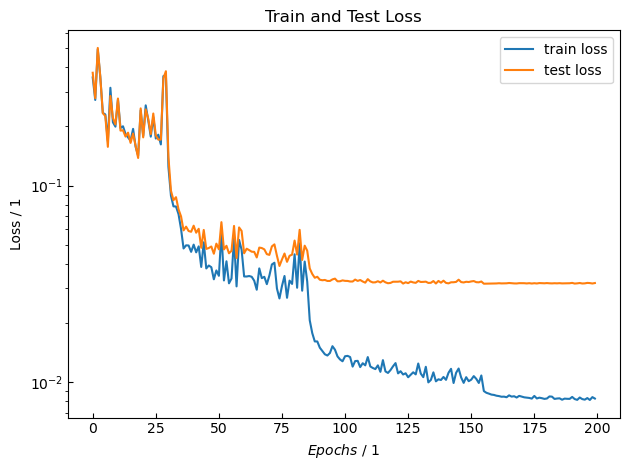

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998082509944531 , R^2(NH3) = 0.9996731239516782
Test Dataset: R^2(H2) = 0.9987319880924008 , R^2(NH3) = 0.9974426846036775
Max Error Training: |x_H2 - x_H2,pred| = 0.021440436547124686 , |x_NH3 - x_NH3,pred| = 0.024036539834828397
Max Error Test: |x_H2 - x_H2,pred| = 0.022368664691247764 , |x_NH3 - x_NH3,pred| = 0.021136010762735247


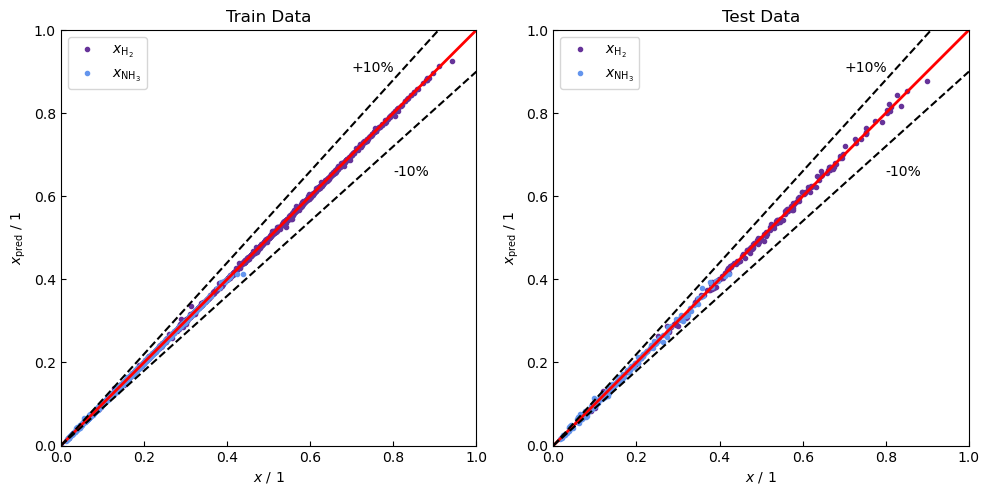

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

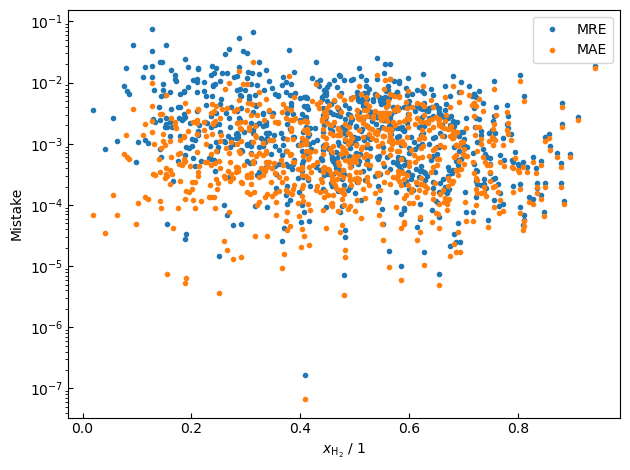

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

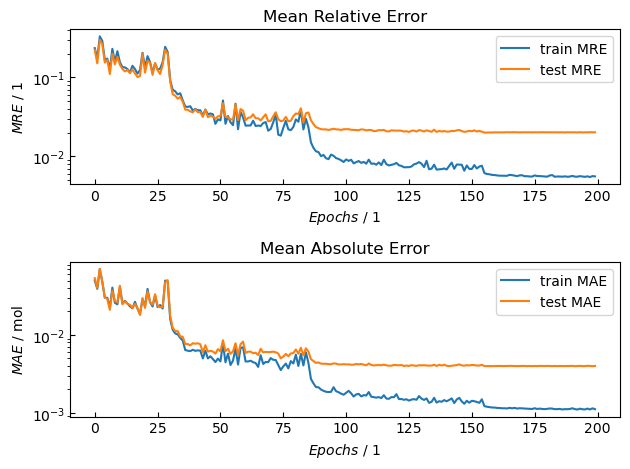

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

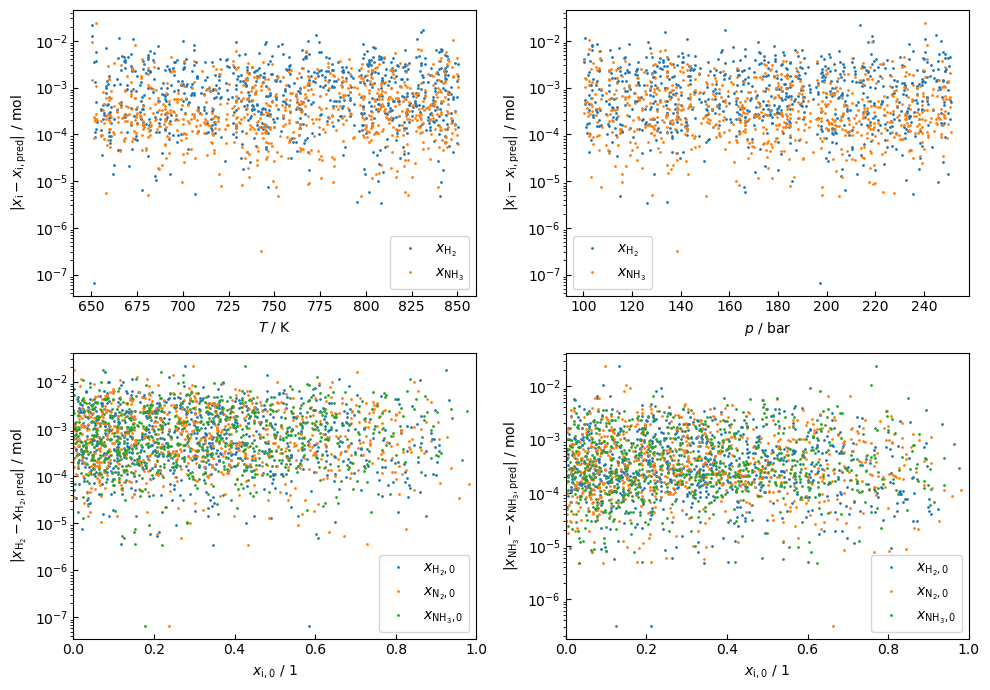

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

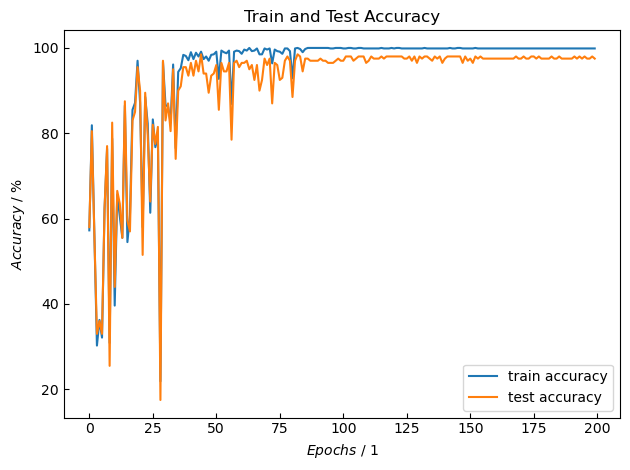

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-0.2806, -0.8661,  0.6571, -0.5221, -0.1112],
        [-1.6077,  1.6608, -0.6660,  0.9604, -0.3280],
        [ 0.1501, -0.4753, -1.2199,  0.4591,  0.7280],
        [ 1.5234,  0.4747,  0.8628,  0.5350, -1.3935],
        [ 0.2298,  1.0088,  2.0413, -0.6286, -1.3608],
        [ 1.1426, -1.6349, -0.6080,  0.8706, -0.2931],
        [-1.3805,  0.1357, -0.8486, -0.8917,  1.7442],
        [ 0.9901,  0.0046,  1.3258, -0.0246, -1.2759],
        [-0.5906,  0.2121, -1.0108,  1.9327, -0.9834],
        [-0.0097,  0.6561,  0.2458, -1.0059,  0.7869],
        [ 0.2071, -1.0022, -1.1003, -1.0869,  2.1908],
        [ 0.8686,  1.2620, -0.6277,  0.1266,  0.4866],
        [-0.4671, -0.2839, -1.1062, -1.3442,  2.4594],
        [-1.7680,  0.4974,  1.0836, -0.4049, -0.6496],
        [-0.9413,  1.6363, -0.9039,  0.7035,  0.1681],
        [ 1.5685,  0.2578,  0.5006, -0.5690,  0.0902]])
tensor([[ 0.5692,  0.2203],
        [-1.5430,  1.0315],
        [-0.3305, -0.3813],
        [-0.1121, -0.8769],
       

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-4.8389e-01,  2.6992e-01, -2.4191e-01,  1.9652e-01, -4.0513e-01],
         [-2.5289e-01, -1.8024e-01, -2.6639e-01, -4.8160e-01,  2.7201e-01],
         [ 6.6510e-03,  7.1155e-02,  2.8271e-01,  4.0002e-01,  3.2726e-01],
         [-3.3111e-01,  1.0728e-01,  3.7875e-01, -2.9714e-01,  7.6953e-02],
         [ 6.3375e-01, -2.5827e-01, -2.6563e-01,  5.8480e-01,  2.2654e-01],
         [-2.9358e-01,  1.0673e-01,  1.9583e-01, -2.0306e-01, -3.3819e-03],
         [-4.1079e-01,  6.9436e-02, -3.9178e-01, -4.9665e-02, -2.3582e-01],
         [-3.3569e-01,  1.1019e-01, -3.9587e-01,  8.4511e-02, -3.8660e-01],
         [-1.4722e-01,  2.8676e-02, -2.7066e-01,  3.1394e-01, -5.5282e-02],
         [-1.1653e-01,  7.2391e-02, -4.2025e-02,  6.8141e-02,  9.8464e-02],
         [ 4.7009e-01, -1.7851e-01,  4.7055e-02, -5.1218e-01,  1.6349e-01],
         [ 4.7889e-01, -7.8338e-01, -2.4985e-01,  1.0345e-01,  8.2856e-02],
         [-7.4822e-02,  1.1594e-01,  1.4230e-01, -5.1469e-01,  2.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0627, 0.8259, 0.3658, 0.1436, 0.7472],
        [0.9401, 0.0279, 0.4841, 0.7983, 0.0770]])
tensor([[ 0.1376,  0.4231],
        [-0.0458, -0.6984]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1433e+00, -5.1337e-01,  5.8081e-01, -1.2671e+00,  7.2509e-01],
        [-8.6265e-01,  4.5460e-01, -1.2893e+00,  4.2004e-01,  8.3602e-01],
        [ 1.2939e+00,  5.1166e-01, -6.5230e-01, -2.8473e-01,  9.3117e-01],
        [-3.3971e-01, -2.8439e-01, -6.9925e-01, -3.8596e-01,  1.0807e+00],
        [-1.7582e+00, -8.4388e-01, -8.6370e-01,  1.9956e+00, -1.1920e+00],
        [ 9.8009e-01,  6.0436e-01, -8.8164e-01,  1.5503e+00, -7.1933e-01],
        [ 1.2444e+00, -1.6702e+00, -9.6640e-01,  1.3150e+00, -3.9564e-01],
        [ 4.4584e-01,  1.1711e+00, -3.1743e-01, -6.7333e-01,  9.9972e-01],
        [ 5.4325e-01,  1.6653e+00, -6.7428e-01,  1.5499e+00, -9.2243e-01],
        [-2.5528e-01,  1.5256e+00,  9.4897e-01,  1.9773e-01, -1.1334e+00],
        [ 1.5021e+00,  2.8137e-01, -1.3550e+00,  7.8357e-01,  5.2888e-01],
        [-1.1908e+00,  7.5697e-01,  2.4176e+00, -1.1297e+00, -1.2180e+00],
        [ 9.1161e-01, -3.6683e-01,  6.0314e-02, -1.8765e-01,  1.3260e-01],
        [-1.5820e-01, -9.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()